In [123]:
import numpy as np
import math
from datascience import *

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots

# 1. The Data set

The dataset is a table of songs, ea with a name, artist, and genre. We will be trying to predict each song's genre.

Only attribute we will use to predict genre of a song are its lyrics. List of just under 5000 words that might occur in a song. For each song, our dataset tells us the frequency w/ each of these words occurs in that song. All words have been converted to owercase. 

In [124]:
lyrics = Table.read_table('https://raw.githubusercontent.com/data-8/data8assets/gh-pages/materials/sp17/project/project3/lyrics.csv')
lyrics.where('Title', 'In Your Eyes').select(0,1,2,3,4,5,'like','love')

Title,Artist,Genre,i,the,you,like,love
In Your Eyes,Alison Krauss,Country,0.107143,0,0.0297619,0.0119048,0.0595238


The cell above prints a few column of the row for the country song 'In Your Eyes' by Alison Krauss. Song contains 168 words. The word 'like' apears twice: $2/168 = 0.0595$ of the words. the word 'the' doesn't appear at all

Our dataset doesn't contain all info about a song. For example, it doesnt describe the roder of words in the song, let along the melody, instruments, rhythym. Nonetheless, you may find that word frequencies alone are sufficient to build and accurate genre classifier. 

All titles are unique. The row_for_title function provides fast access to one row for each title

In [125]:
title_index = lyrics.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster) 
        lyrics.where('Title',title).row(0)
    """
    return title_index.get(title)[0]

for example, the fastest way to find the frequency of "love" in the song In your eyes is to access the 'love' item from its row:

In [126]:
row_for_title('In Your Eyes').item('love')

0.05952381

### Question 1.1:
Set expected_row_sum to the number that you will result from summing all proportions in each row, excluding the first 3 columns

In [127]:
expected_row_sum = lyrics.drop(0,1,2)
expected_row_sum = expected_row_sum.apply(sum)
expected_row_sum

array([1.00000004, 0.99999998, 1.00000009, ..., 1.00000001, 0.99999998,
       1.00000003])

The following cell below generates a histogram of actual row sums. It should confirm your answer above, perhaps with a small amount of error:

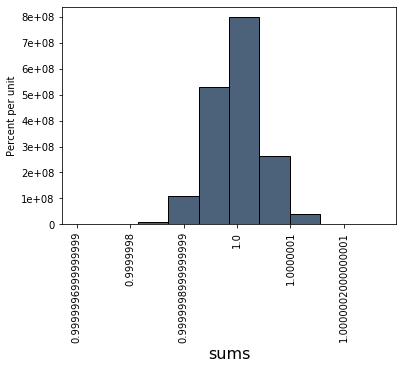

In [128]:
Table().with_column('sums', lyrics.drop([0, 1, 2]).apply(sum)).hist(0)

The dataset was extracted from the Million Song Dataset. Specifically, datasets from musiXmatch and Last.fum

The counts of common words in the lyrics for all of these songs are provided by the musiXmatch dataset (called a bag-of-words format). We converted the words to lowercase, removed the explicit words, and converted the counts to frequencies

The Last.fm dataset contains multiple tags for each song in the Million Song Dataset. Some tags are genre-related such as 'pop', 'punk', 'rock', etc. To construct the Genre column, first we extracted songs with Last.fm tags that included the words 'country', or both 'hip' and 'hop'. These songs were then cross-referenced witht he musiXmatch dataset, and only songs with musiXmatch lyrics were placed in the dataset. 
   

In [129]:
print('Words with frequencies:', lyrics.drop('Title','Artist','Genre').num_columns)
print('Words with genres:', lyrics.num_rows)

Words with frequencies: 4817
Words with genres: 1721


# 1.1: Word Stemming
The columsn other than Title, Artist, Genre in the lyrics table are all words in some of the songs in our dataset. Some of those names have been *Stemmed* or abbreviated heuristically, in an ettempt to make different *inflected* forms of the same base word into the same string.

For example, the column "manag" is the sum of proportions of the words 'manage', 'manager', etc. 

Stemming makes it a little tricky to search for words you want to use, so we have provided another table that will let us see examples of unstemmed versions of each stemmed word. Run the following code below to load the table

In [130]:
vocab_mapping = Table.read_table('https://raw.githubusercontent.com/data-8/data8assets/gh-pages/materials/sp17/project/project3/mxm_reverse_mapping_safe.csv')
stemmed = np.take(lyrics.labels, np.arange(3, len(lyrics.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1110))

Stem,Word
devant,devant
devast,devastation
devil,devil
devot,devotion
devour,devour
dew,dew
di,di
dia,dia
diablo,diablo
dial,dial


### Question 1.1.1:
Assign unchanged to the percentage of words in the vocab_table that are teh same as their stemmed form (such as devour above)

*Hint*: Try using where and comparing the number of rows in a table of only unchanged vocabulary with the number of rows in vocab_table

In [131]:
unchanged = vocab_table.where('Stem', are.equal_to, vocab_table.column('Word')).num_rows
percent_unchanged = unchanged/vocab_table.num_rows
print(round(percent_unchanged, 2), 'percent are unchanged')

0.72 percent are unchanged


### Question 1.1.2:
Assign stememd_message to the stemmed version of the word 'message'.

In [132]:
stemmed_message = vocab_table.where('Word','message').column(0).item(0)
stemmed_message

'messag'

### Question 1.1.3:
Assign unstemmed_singl to the word in vocab_table that has 'singl' as its stemmed form.

In [133]:
unstemmed_singl = vocab_table.where('Stem', 'singl').column(1).item(0)
unstemmed_singl

'single'

### Question 1.1.4:
What word in the vocab_table was shortened the most by this stemming process? 
Assign most_shortened to the word. It's an example of how heuristic stemming can collapse two unrelated words into the same stem (which is bad, but happens a lot in practice anyway)

In [134]:
# In the class solution, we foudn it useful to first make an array
# called shortened contaiing the number of characters that was
# chopped off of each word in vocav_table, but you dont have to do that
def len_string(col):
    col_array = vocab_table.column(col)
    collection = make_array()
    for i in np.arange(len(vocab_table.column(col))):
        word = col_array.item(i)
        word_length = len(word)
        collection = np.append(collection, word_length)
    return collection

shortened = len_string(0)-len_string(1)
shortest = min(shortened)
v_table2 = vocab_table.with_column('Differences', shortened)
most_shortened = v_table2.where('Differences', shortest).column('Word').item(0)
most_shortened

'international'

# 1.2: Splitting the Dataset
We're going to use our lyrics dataset for two purposes:
1) First, we want to *train* song genre classifiers.
2) Second, we want to *test* the performance of our classifiers

Hence, we need two different datasets: *training* and *test*

The purpose of a classifier is to classify unseen data that is similar to the training data. Therefore, we must ensure that there are no songs that appear in both sets.

We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so its easy to split.

We just take the top for training and the rest for test.

Run the following code below (w/o changing it) to sperate the dataset into two tables:

In [135]:

# Here we have defined the proportion of our data
# that we want to designate for training as 11/16ths
# of our total dataset.  5/16ths of the data is
# reserved for testing.

training_proportion = 11/16

num_songs = lyrics.num_rows
num_train = int(num_songs * training_proportion)
num_valid = num_songs - num_train

train_lyrics = lyrics.take(np.arange(num_train))
test_lyrics = lyrics.take(np.arange(num_train, num_songs))

print("Training: ",   train_lyrics.num_rows, ";",
      "Test: ",       test_lyrics.num_rows)

Training:  1183 ; Test:  538


### Question 1.2.1:
Draw a horizontal bar chart with two bars that show the proportion of Country songs in each dataset. Complete the function country_proportion first, it should help you create the bar chart.

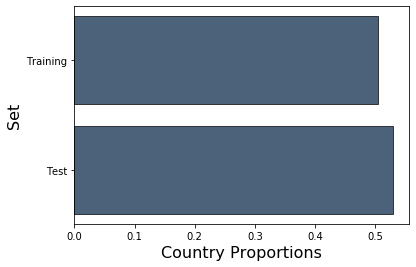

In [136]:
def country_proportion(table):
    """Return the proportion of songs in a table that have a Country genre"""
    country = table.where('Genre', 'Country').num_rows
    return country/table.num_rows
Prop_country = Table().with_columns('Set', make_array('Training', 'Test'),
                                    'Country Proportions', make_array(country_proportion(train_lyrics),
                                                                      country_proportion(test_lyrics))
                                   )
prop_country_bar = Prop_country.barh(0,1)

# 2. K-Nearest Neighbors - a Guided Example

K-Nearest Neighbors (k-NN) is a classification algorithm

Given some *attributes* (also called *features*) of an unseen example, it decideds wehther that exmaple belongs to one or the other of two categories based on its similarity to previously seen examples. 

Predicting the category of an example is called *labeling* and th predicted caregory is also called a *label*

An attribute (feature) we have about each song is the *proportion of times a particular word appears in the lyrics*, and the labels are two music genres: Country and Hiphop.

The algorith requires many previously seen examples for which both the attributes and labels are known: thats the train_lyrics table

To build understanding, we're going to visualize the algorith instead of just describing it

# 2.1: Classifying a song

in k-NN, we classify a song by: finding the k songs in the *training set* that are most similar according to the features we choose. We call those songs w/ similar features the *nearest neighbors*. The k-NN algoorith assigns the most common category among its k-nearest neighbors

Let's limit ourselves to just 2 features for now, so we can plot each song. The features we will use are the proportions of the words "like" and "love" in the lyrics. Taking the song "In Your Eyes" (in the test set), 0.0119 of its words are "like" and 0.0595 are "love". This song appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise. We will say that the distance between two songs is the straight-line distance between them when we plot their features in a scatter diagram. This distance is called the Euclidean ("yoo-KLID-ee-un") distance.

For example, in the song Insane in the Brain (in the training set), 0.0203 of all the words in the song are "like" and 0 are "love". Its distance from In Your Eyes on this 2-word feature set is $\sqrt{(0.0119 - 0.0203)^2 + (0.0595 - 0)^2} \approx 0.06$. (If we included more or different features, the distance could be different.)

A third song, Sangria Wine (in the training set), is 0.0044 "like" and 0.0925 "love".

The function below creates a plot to display the "like" and "love" features of a test song and some training songs. As you can see in the result, In Your Eyes is more similar to Sangria Wine than to Insane in the Brain.

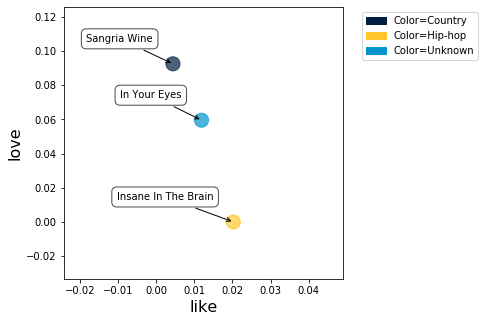

In [137]:
# Just run this cell.

def plot_with_two_features(test_song, training_songs, x_feature, y_feature):
    """Plot a test song and training songs using two features."""
    test_row = row_for_title(test_song)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['Unknown'],
            'Title',   [test_song]
        )
    for song in training_songs:
        row = row_for_title(song)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), song])
    distances.scatter(x_feature, y_feature, colors='Color', labels='Title', s=200)
    
training = ["Sangria Wine", "Insane In The Brain"]
plot_with_two_features("In Your Eyes", training, "like", "love")

### Question 2.1.1: 
Compute the distance between the two country songs, In Your Eyes and Sangria Wine, using the like and love features only. Assign it the name country_distance.

Note: If you have a row object, you can use item to get a value from a column by its name. For example, if r is a row, then r.item("Genre") is the value in column "Genre" in row r.

Note 2: You can quickly get the row from the lyrics table via row_for_title. For example, if "Insane In The Brain" is the song title, then row_for_title("Insane In The Brain") is the row object for this song.

In [138]:
in_your_eyes = row_for_title("In Your Eyes")
sangria_wine = row_for_title("Sangria Wine")
in_your_eyes_distances = make_array(in_your_eyes.item('like'), in_your_eyes.item('love'))
sangria_distances = make_array(sangria_wine.item('like'), sangria_wine.item('love'))

country_distance = np.sqrt(np.sum((in_your_eyes_distances-sangria_distances)**2))
country_distance

0.03382894432459689

### Question 2.1.2:
Complete the function distance_two_features that computes the Euclidean distance between any two songs, using two features

the last two lines call your function to show that *Lookin' for Love* is closer to *In Your Eyes* than *Insane in the Brain*

In [139]:
def distance_two_features(title0,title1,x_feature,y_feature):
    """Compute the distance between two songs with titles title0 and title1
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = row_for_title(title0)
    row1 = row_for_title(title1)
    
    distance0 = make_array(row0.item(x_feature), row0.item(y_feature))
    distance1 = make_array(row1.item(x_feature), row1.item(y_feature))
    return np.sqrt(np.sum(distance0-distance1)**2)

for song in make_array("Lookin' for Love", "Insane In The Brain"):
    song_distance = distance_two_features(song, "In Your Eyes", "like", "love")
    print(song, 'distance:\t', song_distance)

Lookin' for Love distance:	 0.020265774000000007
Insane In The Brain distance:	 0.051158300000000004


### Question 2.1.3:
Define the function distane_from_in_your_eyes so that it works as describes in its documentation:

In [140]:
def distance_from_in_your_eyes(title):
    """The distance between the given song and "In Your Eyes", based on the features "like" and "love".
    
    This function takes a single argument:
      title: A string, the name of a song.
    """
    return distance_two_features('In Your Eyes', title, 'like','love')

### Question 2.1.4:
Using the features 'like' and 'love', what are the names and genres of the 7 songs in the *training set* closest to 'In Your Eyes'?

To answer this question, make a table named close_songs with those 7 songs w/ columns "Title", "Genre", "like", "love", as well as "distance" from 'In Your Eyes'.

Table should be sorted in ascending order by distance

In [141]:
close_tbl = train_lyrics.select('Title', 'Artist', 'Genre', 'like', 'love')
close = close_tbl.apply(distance_from_in_your_eyes, 'Title')
close_songs = close_tbl.with_column('distance', close).sort('distance').take(np.arange(7))
close_songs.select('Title','Genre')

Title,Genre
The Rhythm Of The Pourin' Rain,Country
Your Love Gets Sweeter,Hip-hop
The Way Love Looks,Country
Simple Love,Country
Rockstar Mentality,Hip-hop
All My Love,Hip-hop
The Hardest Part,Country


### Question 2.1.5:
Define the function most_common so that it words as described in the documentation below:


In [142]:

def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in that column of that table.
    In case of a tie, it returns any one of the most common values
    """
    most = table.group(label).sort(1, descending=True).column(0).item(0)
    return most
    

# Calling most_common on your table of 7 nearest neighbors classifies
# "In Your Eyes" as a country song, 4 votes to 3.
most_common('Genre', close_songs)

'Country'

# 3. Features
Now, we're going to extend our classifier to xonsider more than two features at a time.

Euclidean distance still makes sense w/ more than two features.


For n different feautres:
    1) we compute the distance between corresponding feature values for two songs
    2) square each of the n differences
    3) sum up the resulting numbers
    4) take the square root of the sum

# 3.1: Creating your own feature set
Unfortunately, using all of the features has some downsides. 

One clear downside is computational -- computing Euclidean distances just takes a long time when we have lots of features. You might have noticed that in the last question!

So we're going to select just 20. 

We'd like to choose features that are very discriminative. 

That is, features which lead us to correctly classify as much of the test set as possible. 

This process of choosing features that will make a classifier work well is sometimes called *feature selection*, or more broadly *feature engineering*.

### Question 3.1.1:
Look through the list of features (the labels of the lyrics table after the first three). 

Choose 20 common words that you think might let you distinguish between country and hip-hop songs. 

Make sure to choose words that are frequent enough that every song contains at least one of them. Don't just choose the 20 most frequent, though... you can do much better.

You might want to come back to this question later to improve your list, once you've seen how to evaluate your classifier. The first time you answer this question, spend some time looking through the features, but not more than 15 minutes.

In [266]:
my_20_features = make_array('love','down','yeah','heart','gonna',
                            'girl', 'sweet', 'road', 'gave', 'my',
                            'she', 'thing', 'he', 'right', 'man',
                            'not', 'we', 'time', 'go', 'up'
                           )
train_20 = train_lyrics.select(my_20_features)
test_20 = test_lyrics.select(my_20_features)

Next, let us classify the first song from our test set using these features. You can examine the song by running the cells below.

In [267]:
print("Song:")
test_lyrics.take(0).select('Title', 'Artist', 'Genre').show()
print("Features:")
test_20.take(0).show()

Song:


Title,Artist,Genre
That Kind of Love,Alison Krauss,Country


Features:


love,down,yeah,heart,gonna,girl,sweet,road,gave,my,she,thing,he,right,man,not,we,time,go,up
0.026455,0,0,0.015873,0,0,0.005291,0,0,0.015873,0,0,0,0,0,0.026455,0.042328,0,0.005291,0


As before, we want to look for the songs in the training set that are most alike our test song. 

We will calculate the Euclidean distances from the test song (using the 20 selected features) to all songs in the training set. 

You could do this with a for loop, but to make it computationally faster, we have provided a function, fast_distances, to do this for you. 

Read its documentation to make sure you understand what it does. (You don't need to read the code in its body unless you want to.)

In [268]:
def fast_distances(test_row, train_rows):
    """An array of the distances between test_row and each row in train_rows.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test song (e.g., test_20.row(0)).
      train_rows: A table of features (for example, the whole
        table train_20)."""
    assert train_rows.num_columns < 50, "Make sure you're not using all the features of the lyrics table."
    counts_matrix = np.asmatrix(train_rows.columns).transpose()
    diff = np.tile(np.array(test_row), [counts_matrix.shape[0], 1]) - counts_matrix
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    return distances

### Question 3.1.3: (skip 3.1.2)
Use the fast_distances function provided to compute the distance from the first song in the test set to all the songs in the training set, using your set of 20 Features

make a new table called genre_and_distances with one row for each song in the training set and 2 columns: genre (of training song) and distance (from the frist song in the test set)

ensure that genre_and_distances is sorted in increasing order by distance to the first test song.

In [269]:
distances_array = fast_distances(test_20.row(0), train_20)
genre_and_distances = train_lyrics.with_column('Distance', distances_array)
genre_and_distances = genre_and_distances.select('Genre', 'Distance').sort('Distance')
genre_and_distances

Genre,Distance
Hip-hop,0.0270386
Hip-hop,0.0277643
Country,0.0281418
Country,0.03181
Hip-hop,0.032378
Hip-hop,0.0327127
Country,0.0329362
Country,0.0332303
Hip-hop,0.0336385
Hip-hop,0.0344833


### Question 3.1.4: 
Now compute the 5-nearest neighbors classification of the first song in the test set. 

That is, decide on its genre by finding the most common genre among its 5 nearest neighbors, according to the distances you've calculated.

Then check whether your classifier chose the right genre. (Depending on the features you chose, your classifier might not get this song right, and that's okay.)

In [270]:
#Set my_assigned_genre to the most common genre among these.
my_assigned_genre = genre_and_distances.take(np.arange(5)).group('Genre').column(0).item(0)

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first song in the test set.
my_assigned_genre_was_correct = my_assigned_genre == test_lyrics.take(0).column('Genre').item(0)

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

The assigned genre, Country, was correct.


# 3.2: A Classifier Function
Now we can write a single function that encapsulates the whole process of classification. 

### Question 3.2.1:
Write a function called classify

it should take 4 arguments:
- 1) row of features for a song to classify (ex: test_20.row(0)))
- 2) table w/ a column for each feature (ex: train_20)
- 3) array of clases that has as many items as the previous table has rows, and in the same order
- 4) k, number of neighbors to use in classification

It should return the class a k-nearest neighbor classifier picks for the givern row of features (the string 'Country' or 'Hip Hop').

In [271]:
def classify(test_row, train_rows, train_classes, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_rows)
    genre_and_distances = Table().with_columns('Genre', train_classes,
                                             'Distance', distances
                                             ).sort('Distance')
    k_closest_grouped = genre_and_distances.take(np.arange(k)).group('Genre')
    k_closest = k_closest_grouped.sort('count', descending=True).column(0).item(0)
    return k_closest

'Country'

### Question 3.2.2:
Assign granpa_genre to the genre predicted by your classifier for the song 'Grandpa Got Runned OVer By A John Deere' using 9 neighbors and using 20 features

In [273]:
grandpa_features = lyrics.where('Title', 'Grandpa Got Runned Over By A John Deere').drop(0,1,2).select(my_20_features).row(0)
grandpa_genre = classify(grandpa_features, train_20, train_lyrics.column('Genre'), 9)
grandpa_genre

'Country'

### Question 3.2.3:
Create a classification function that takes as its argument a row containing your 20 features and classifies that row using the 5-nn alogirth with train_20 as its training set:

In [280]:
def classify_one_argument(row):
    return classify(row, train_20, train_lyrics.column('Genre'), 5)
classify_one_argument(test_20.row(0))

'Hip-hop'

# 3.3: Evaluating Your Classifier
Now lets see how accurate this is on the whole test set

### Question 3.3.1:
Use classify_one_argument and apply to class every song in the test set.
Name these guesses test_guesses.
Then finally, compute the prop of correct classifications

In [286]:
test_guesses = test_20.apply(classify_one_argument)
proportion_correct = test_guesses == test_lyrics.column('Genre')
proportion_correct = np.count_nonzero(proportion_correct) / test_lyrics.num_rows
proportion_correct

0.6988847583643123

# 4. Extra Explorations
Now that we know how to evaluate a classifier, its time to build a better one

### Question 4.1:
Find a classifier with a better test-set accuracy than classify_one_argument 

Your new f(x) should have same args as classify_one_argument and return a classification. Name it another_classifier

You can use more or different features, or you can try differnt values of k

In [296]:
# To start you off, here's a list of possibly-useful features:
staff_features = make_array("come", "do", "have", "heart", "make", "never", "now", "wanna", "with", "yo")

train_staff = train_lyrics.select(staff_features)
test_staff = test_lyrics.select(staff_features)

def another_classifier(row):
    return classify(row, train_staff, train_lyrics.column('Genre'), 5)
another_classifier(test_staff.row(0))

test_guesses_2 = test_staff.apply(another_classifier)
proportion_correct_2 = test_guesses_2 == test_lyrics.column('Genre')
proportion_correct_2 = np.count_nonzero(proportion_correct_2) / test_lyrics.num_rows
proportion_correct_2

0.741635687732342